<a href="https://colab.research.google.com/github/nbenck/Jupyter_code/blob/main/An%C3%A1lise_SDSS_atual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Google e bibliotecas

In [ ]:
from google.colab import drive
import os
import shutil

# Remove existing content in the mountpoint if it exists
# if os.path.exists('/content/drive'):
#     shutil.rmtree('/content/drive')
#     print("Removed existing /content/drive directory.")

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Bibliotecas

In [ ]:
!pip install astropy;
!pip install healpy;
!pip install numpy;
!pip install mathplotlib-venn;
!pip install pandas;
#!pip install dask[complete];
!pip install SciencePlots;

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 56.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement mathplotlib-venn (from versions: none)
ERROR: No matching distribution found for mathplotlib-venn


In [ ]:
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import astropy.units as u
import astropy.cosmology.units as cu
import os
#import dask.dataframe as dd
import pandas as pd
z = 1100 * cu.redshift
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde

# Processamento de gráficos

Processamento de dados em fits, formação de gráficos para parâmetros MFMTK's em eixos de M* vs fil_dist e M* vs redshift ($fildist = [0,10]$, $redshift = [0.1, 0.5]$, $logMstars =[9.5, 11.7]$, $QF = 0$ e $q=a/b > 0.7$).

Observa-se que há dados de densidade dos filamentos na tabela 2 do catálogo de filamentos de Tempel et al. (2014).

##Massa estelar vs fildist

In [ ]:
# @title
#Mesmo gráfico que o superior
#Deixaro código igual ao redshift  ---- sem escala de y padronizada
#Em logaritmo (principal)
df = pd.read_csv("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/mfmtk_sdss_z_qf,ab.csv")
df.columns = [c.lower() for c in df.columns]

#Limites e parâmetros
lowmassmask = df['logmstars'] < 10.5
highmassmask = df['logmstars'] >= 10.5

parametros_restantes = ["a1", "a3", "c1", "c2", "s1", "s3", "h", "nfit2d", "redshift_1", "l1.0", "l0.5", "ng.5", "ng1", "g", "m20", "sigma_psi", "logsfr"]
#parametros_restantes = ["a1", "a3", "c1", "c2"] #para testar mudanças no código ou utilizar o modo playground

# Define base_dir
base_dir = "/content/drive/MyDrive/analises_galaxias_setore_novo"

#Análise e plotagem
for param in parametros_restantes:
    print(f"Geração de: {param}")


    fig, ax = plt.subplots(figsize=(20, 10))


    sns.kdeplot(x=df[lowmassmask]["fil_dist"], y=df[lowmassmask][param], ax=ax, label='Low Mass KDE', fill=False, linestyles='--', levels=5)
    sns.kdeplot(x=df[highmassmask]["fil_dist"], y=df[highmassmask][param], ax=ax, label='High Mass KDE', fill=False, levels=5)


    ax.scatter(x=df["fil_dist"], y=df[param], s=3, alpha=0.2, color="black", edgecolors="none", zorder=3)


    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_ylabel("fil_dist")
    ax.set_xlabel(param)

    #ax.set_ylim(y_min_global, y_max_global)


    ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.grid(alpha=0.3)
    plt.minorticks_on()
    plt.title(f"{param}")

   #Gerar diretório para os plots combinados
    combined_plots_dir = os.path.join(base_dir, "combined_plots_subplots_KDE")
    os.makedirs(combined_plots_dir, exist_ok=True)

    #Salvar
    plot_filename = os.path.join(combined_plots_dir, f"{param}_combinado_log.png")
    plt.savefig(plot_filename)
    #plt.show()
    plt.close()

##Com hist2d implementado


##Teste com hist2d (código abaixo é o principal)!!!

In [ ]:
# @title
from matplotlib.colors import LogNorm

#Em logaritmo (teste com hist2d adaptado)
df = pd.read_csv("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/mfmtk_sdss_z_qf,ab.csv")
df.columns = [c.lower() for c in df.columns]

#Base diretória
base_dir = "/content/drive/MyDrive/analises_galaxias_setore_novo"

lowmassmask = df['logmstars'] < 10.5
highmassmask = df['logmstars'] >= 10.5

parametros_restantes = ["a1", "a3", "c1", "c2", "s1", "s3", "h", "nfit2d",
                        "redshift_1", "g", "sigma_psi", "logsfr"]

for param in parametros_restantes:

    fig, ax = plt.subplots(figsize=(24,12))
    # ---------- MASK PRINCIPAL x>0 ------------
    mask_valid = (
        np.isfinite(df["fil_dist"]) &
        np.isfinite(df[param])
        #(df["fil_dist"] > 0)
    )

    x_valid = df["fil_dist"][mask_valid]
    y_valid = df[param][mask_valid]

    # ---------- HIST2D ----------
    h = ax.hist2d(
        x_valid, y_valid,
        bins=60,
        norm=LogNorm(),
        cmap='viridis',
        zorder=1
    )
    plt.colorbar(h[3], ax=ax, label='Densidade (hist2d)')
# Estes parâmetros estavam dando problema:
    xmin, xmax = np.percentile(x_valid, [1, 99])
    ax.set_xlim(xmin, xmax)

    if param == "a1":
        ymin, ymax = np.percentile(y_valid, [1, 99])
        ax.set_ylim(ymin, ymax)

    if param == "logsfr":
        ymin, ymax = np.percentile(y_valid, [1, 99])
        ax.set_ylim(ymin, ymax)

    # ---------- MASKS MASSAS ----------
    mask_low  = mask_valid & lowmassmask
    mask_high = mask_valid & highmassmask

    # ---------- KDE ----------
    sns.kdeplot(
        x=df["fil_dist"][mask_low],
        y=df[param][mask_low],
        ax=ax, label='Low Mass KDE',
        fill=False, linestyles='--', levels=5, zorder=3
    )

    sns.kdeplot(
        x=df["fil_dist"][mask_high],
        y=df[param][mask_high],
        ax=ax, label='High Mass KDE',
        fill=False, levels=5, zorder=3
    )

    # ---------- SCATTER ----------
    ax.scatter(
        x_valid, y_valid,
        s=3, alpha=0.2, color="white",
        edgecolors="none", zorder=4
    )

    # ---------- EIXOS ----------
    ax.set_yscale('log')
    ax.set_ylabel("fil_dist")
    ax.set_xlabel(param)

    ax.legend()
    plt.grid(alpha=0.3)
    plt.minorticks_on()
    plt.title(param)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    combined_plots_dir = os.path.join(base_dir, "plots_hist2d_yfildist")
    os.makedirs(combined_plots_dir, exist_ok=True)
    plot_filename = os.path.join(combined_plots_dir, f"{param}_hist_fil.png")
    plt.savefig(plot_filename)

    plt.show()
    plt.close()


Valores numéricos de dados para as máscaras (tabela de médias para parâmetros por fil_dist)

In [ ]:
# @title
# carregar tabela
tabela = Table.read("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/MFMTK_SDSS_clusters_z_logmstars.fits", format="fits")
df = tabela.to_pandas()
df.columns = [c.lower() for c in df.columns]

# diretório de saída
out_dir = "/content/drive/MyDrive/analises_galaxias_setore_novo/tabelas_por_bin"
os.makedirs(out_dir, exist_ok=True)

# definição dos bins
bins = np.arange(0, 11, 1)

# lista dos parâmetros
parametros_restantes = [
    "a1", "a3", "c1", "c2", "s1", "s3", "h", "nfit2d",
    "redshift_1", "l1.0", "l0.5", "ng.5", "ng1",
    "g", "m20", "sigma_psi", "logsfr"
]

todas_linhas = []

for param in parametros_restantes:

    for i in range(len(bins) - 1):

        bin_mask = (
            (df["fil_dist"] >= bins[i]) &
            (df["fil_dist"] < bins[i+1])
        )

        mean_low = df.loc[
            bin_mask & (df["logmstars"] < 10.5), param
        ].mean()

        mean_high = df.loc[
            bin_mask & (df["logmstars"] >= 10.5), param
        ].mean()

        todas_linhas.append({
            "parametro": param,
            "fil_dist_bin": f"{bins[i]}–{bins[i+1]}",
            "mean_low": mean_low,
            "mean_high": mean_high
        })

# gerar DataFrame único
df_final = pd.DataFrame(todas_linhas)

# salvar UM único CSV
output_file = os.path.join(out_dir, "parametros_bins_low_high.csv")
df_final.to_csv(output_file, index=False)

print(df_final)



Histograma para as máscaras de $M^{*}$.

Histograma low vs high mass para fil_dist


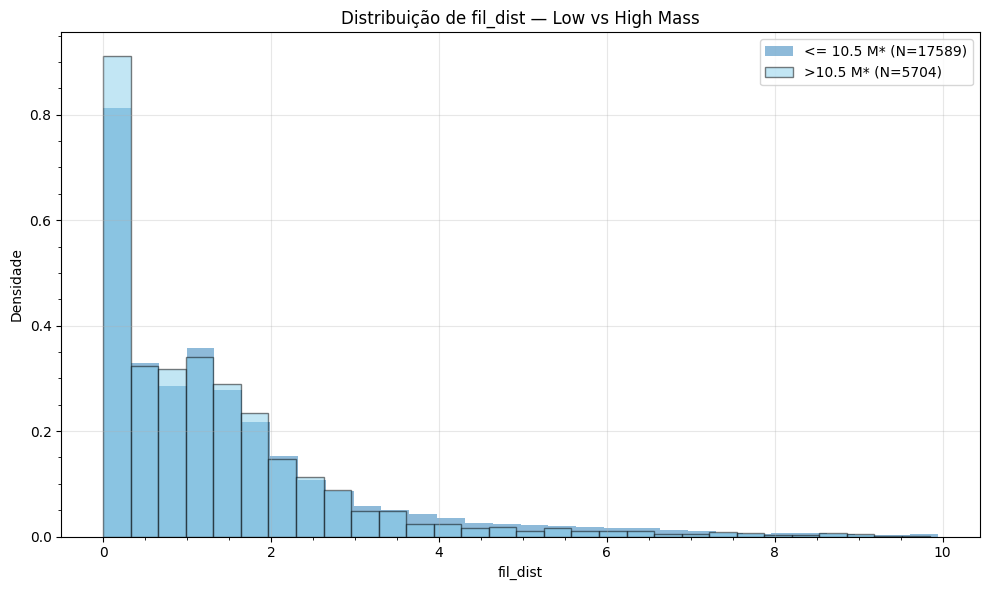

Histograma low vs high mass para a1


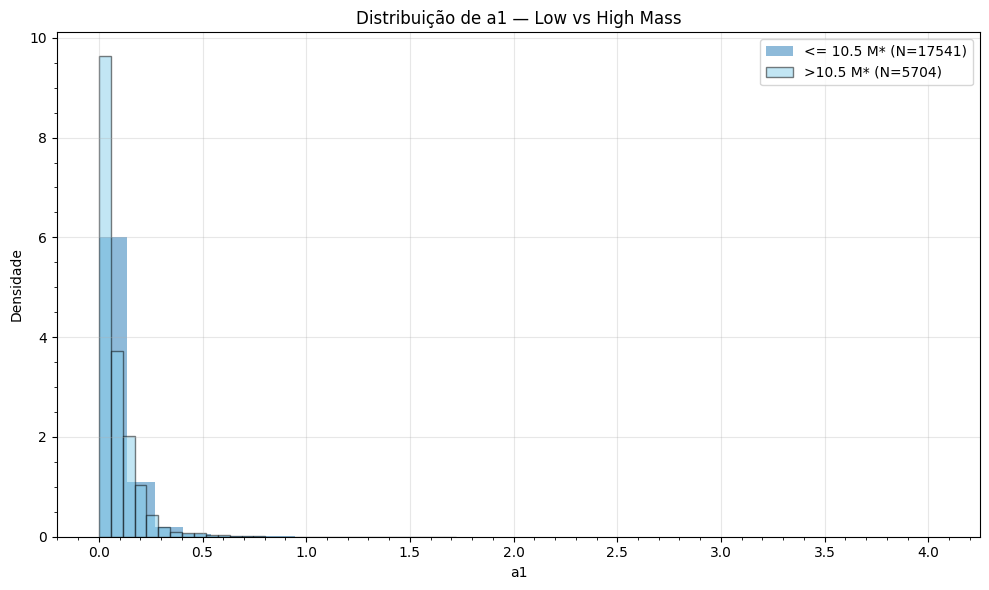

Histograma low vs high mass para a3


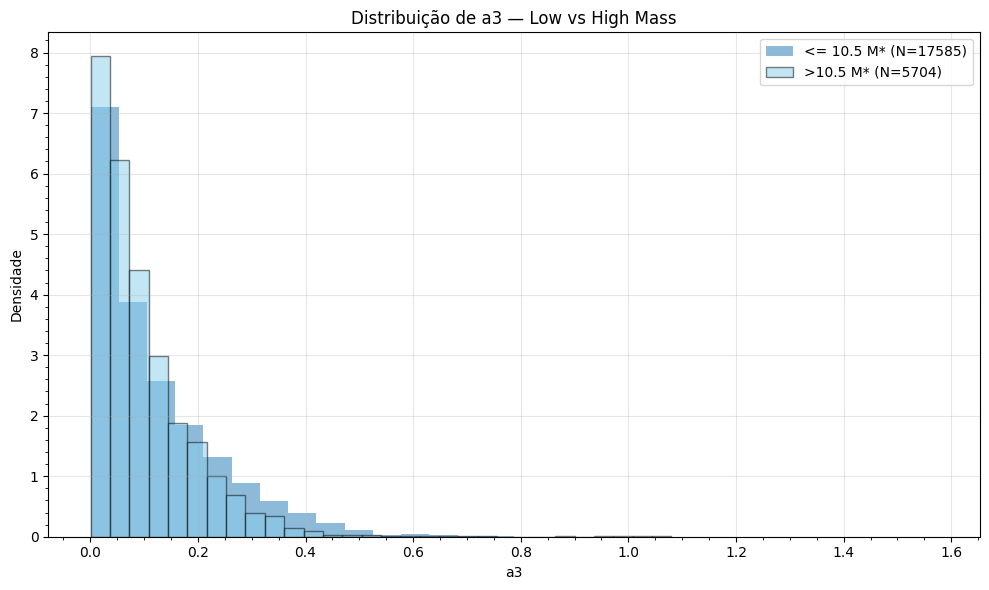

Histograma low vs high mass para s1


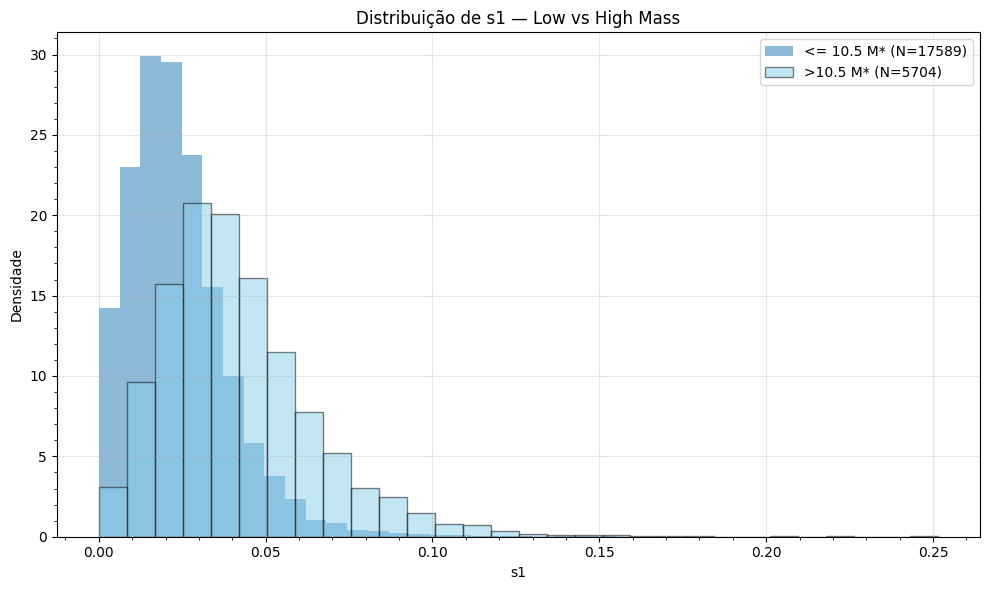

Histograma low vs high mass para s3


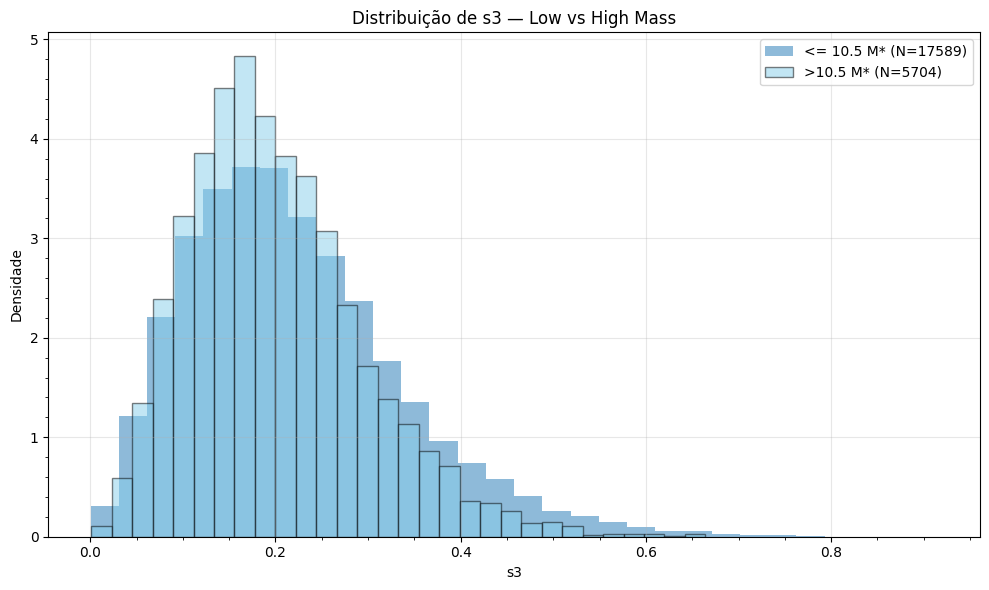

Histograma low vs high mass para c1


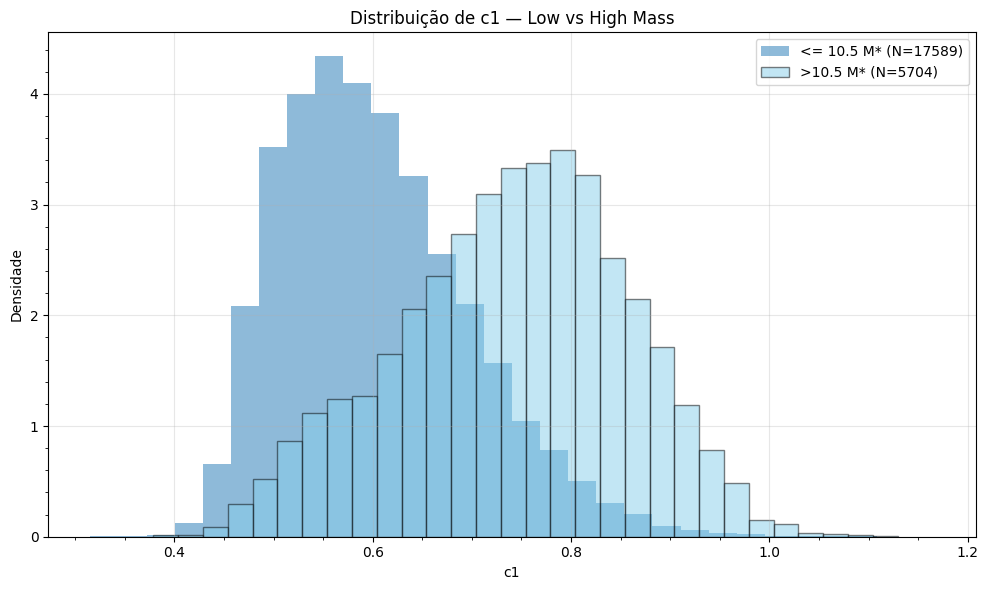

Histograma low vs high mass para c2


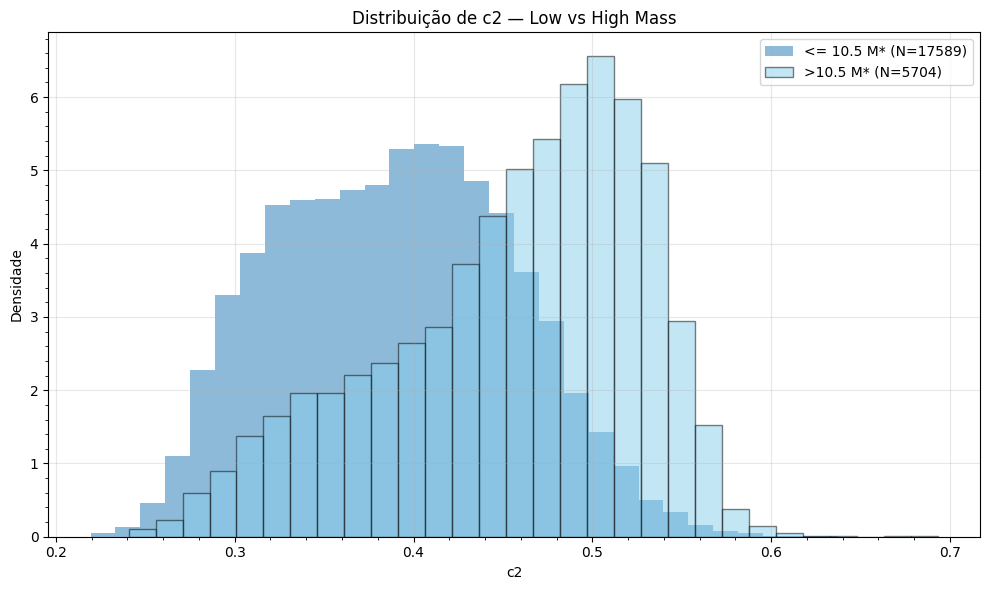

Histograma low vs high mass para h


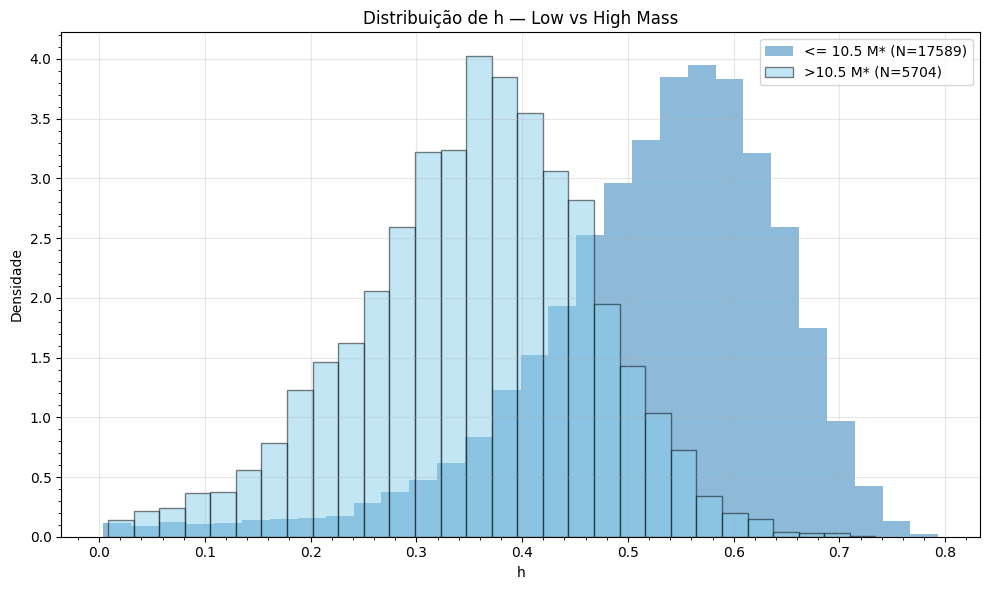

Histograma low vs high mass para nfit2d


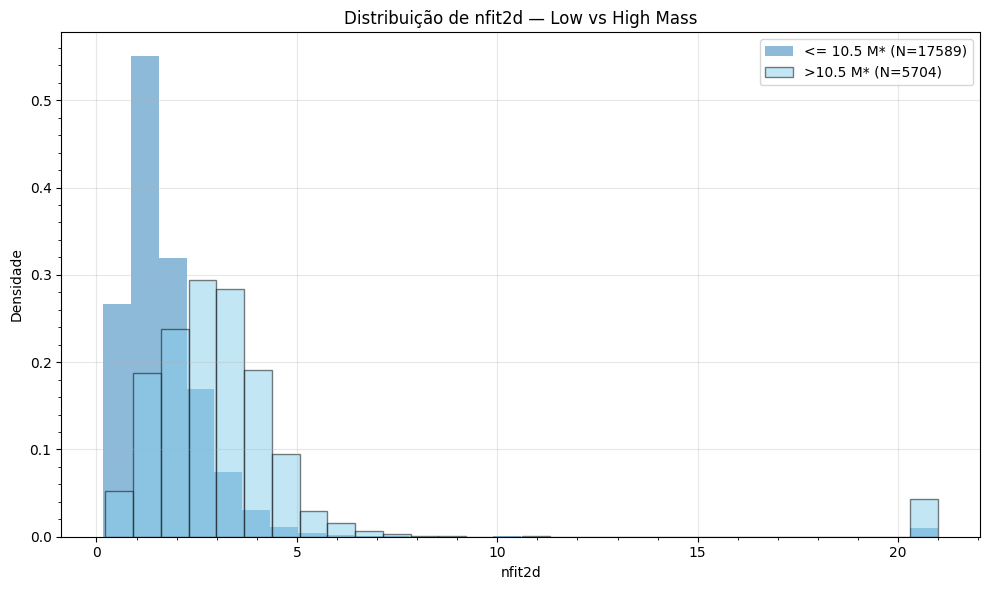

Histograma low vs high mass para redshift_1


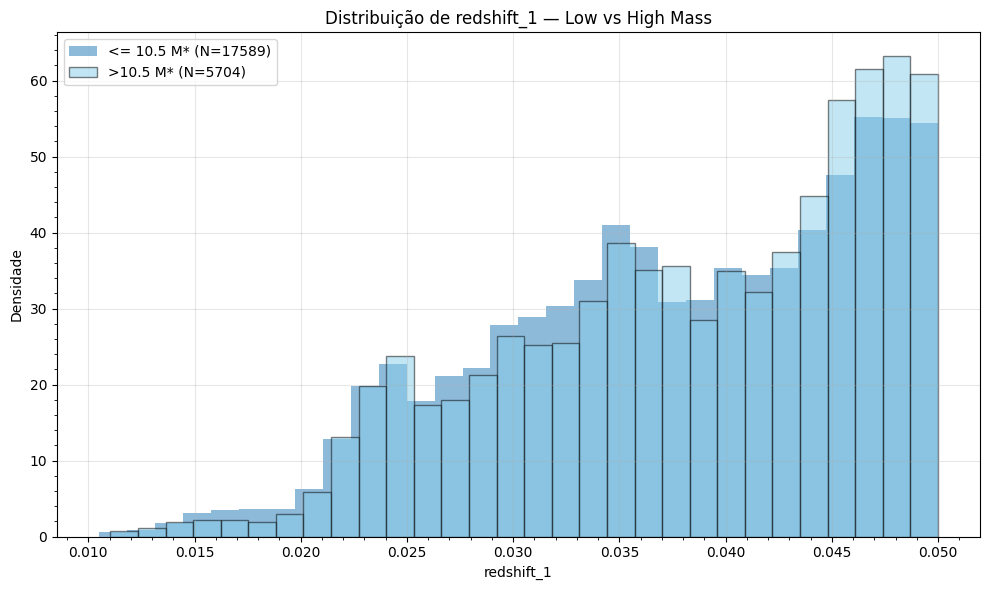

Histograma low vs high mass para g


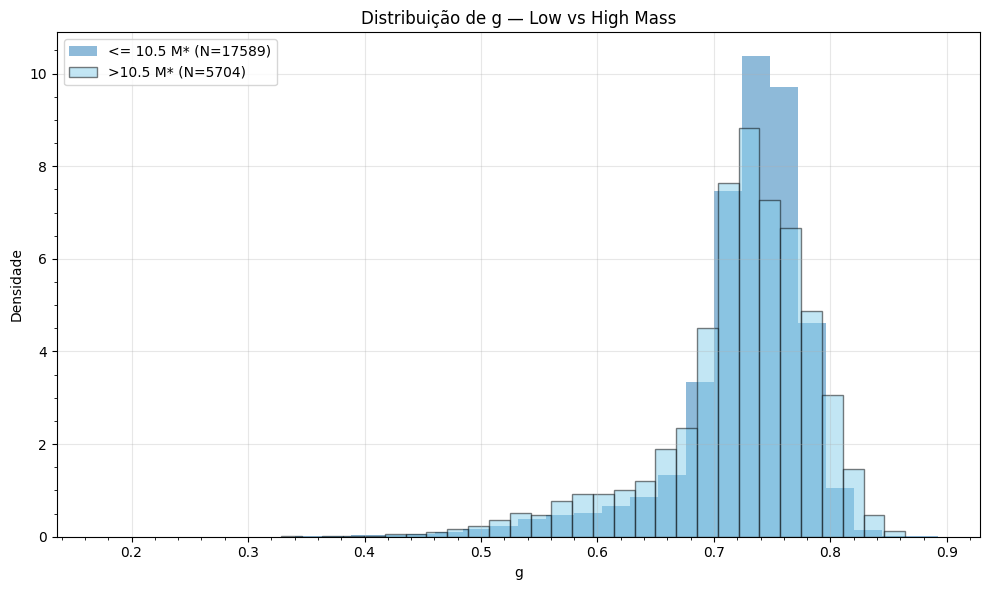

Histograma low vs high mass para m20


/tmp/ipython-input-732874304.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


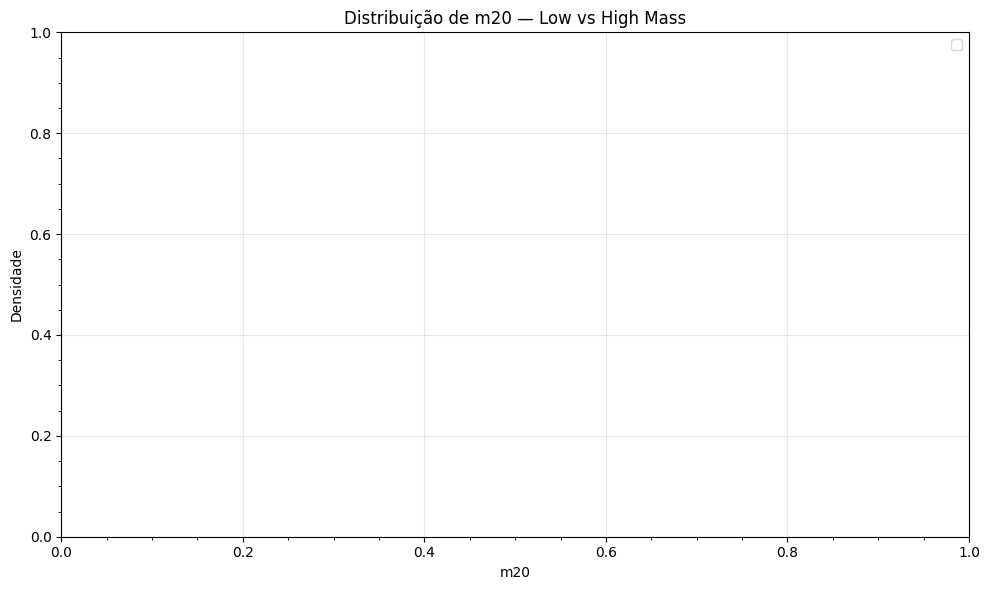

Histograma low vs high mass para sigma_psi


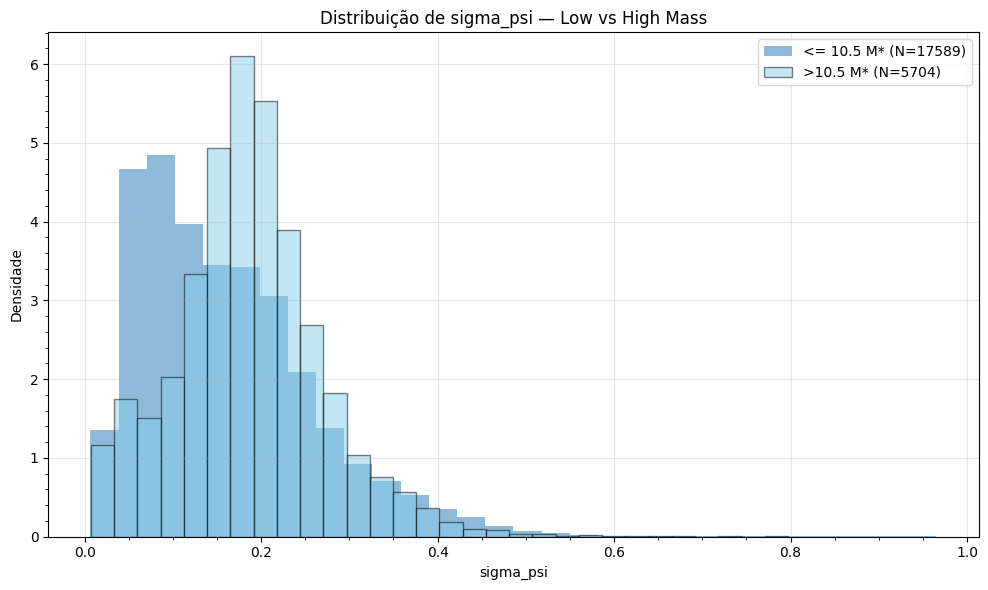

Histograma low vs high mass para logsfr


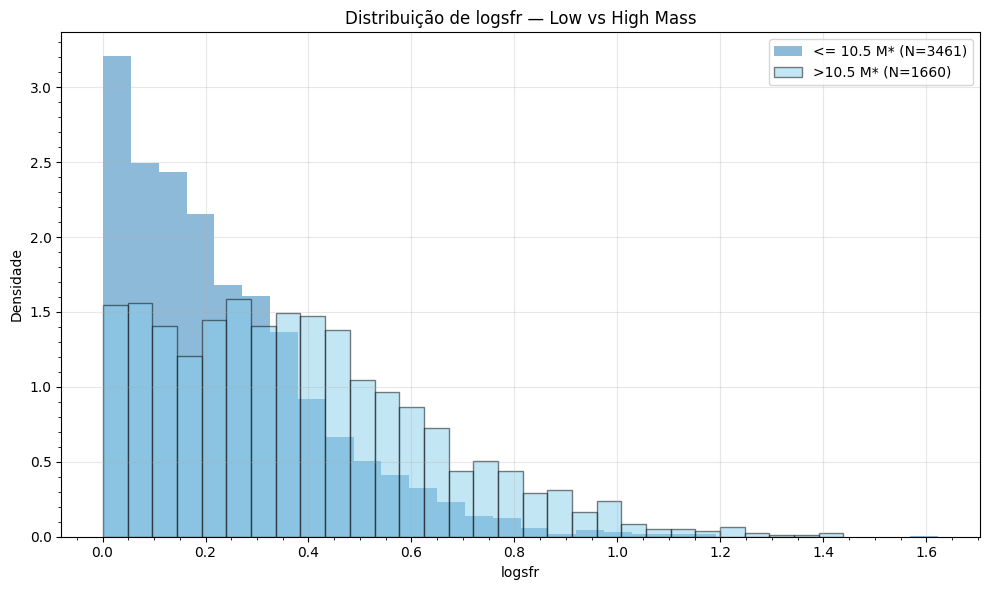

In [ ]:
#Histogramas (M*)
# @title
#Tabela
tabela = Table.read("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/MFMTK_SDSS_clusters_z_logmstars.fits", format="fits")
df = tabela.to_pandas()
df.columns = [c.lower() for c in df.columns]

#Colunas
#col_morf = 'morf'
col_fildist = 'fil_dist'
#col_len = 'len'
col_logMstars = 'logmstars'
#col_cor = 'tipo'

#Limites
lowmassmask = df['logmstars'] < 10.5
highmassmask = df['logmstars'] >= 10.5

y_min_global = np.inf
y_max_global = -np.inf

#Parâmetros MFMTK's
parametros_restantes = ["fil_dist", "a1", "a3", "s1", "s3", "c1", "c2", "h", "nfit2d", "redshift_1", "g", "m20", "sigma_psi", "logsfr"]

for param in parametros_restantes:
    valores_positivos = df[param][df[param] > 0]

    if not valores_positivos.empty:
        # Atualiza o mínimo global se encontrar um valor menor
        y_min_global = min(y_min_global, valores_positivos.min())
        # Atualiza o máximo global se encontrar um valor maior
        y_max_global = max(y_max_global, valores_positivos.max())

#Saída
base_dir = "/content/drive/MyDrive/analises_galaxias_setore_novo"
morf_plots_dir = os.path.join(base_dir, "mstars_histograms")
os.makedirs(morf_plots_dir, exist_ok=True)

for param in parametros_restantes:
    print(f"Histograma low vs high mass para {param}")

    plt.figure(figsize=(10, 6))
    plt.title(f"Distribuição de {param} — Low vs High Mass")
    plt.xlabel(param)
    plt.ylabel("Densidade")
    plt.grid(alpha=0.3)
    plt.minorticks_on()

    # --- LOW MASS ---
    data_low = df.loc[
        (df[col_logMstars] < 10.5) & (df[param] > 0),
        param
    ].dropna()

    # --- HIGH MASS ---
    data_high = df.loc[
        (df[col_logMstars] >= 10.5) & (df[param] > 0),
        param
    ].dropna()

    if not data_low.empty:
        plt.hist(
            data_low,
            bins=30,
            density=True,
            alpha=0.5,
            label=f"<= 10.5 M* (N={len(data_low)})"
        )

    if not data_high.empty:
        plt.hist(
            data_high,
            bins=30,
            density=True,
            alpha=0.5,
            color='skyblue',
            edgecolor='black',
            label=f">10.5 M* (N={len(data_high)})"
        )
    #colorbar - REMOVED: Histograms do not produce mappable objects for colorbars.
    #plt.colorbar(label='fil_dist')

    plt.legend()
    plt.tight_layout()
    plot_filename = os.path.join(morf_plots_dir, f"{param}_his_Mstar.png")
    plt.savefig(plot_filename)
    plt.show()
    plt.close()

Com média em relação a fil_dist.

Histograma + média vs distância para a1


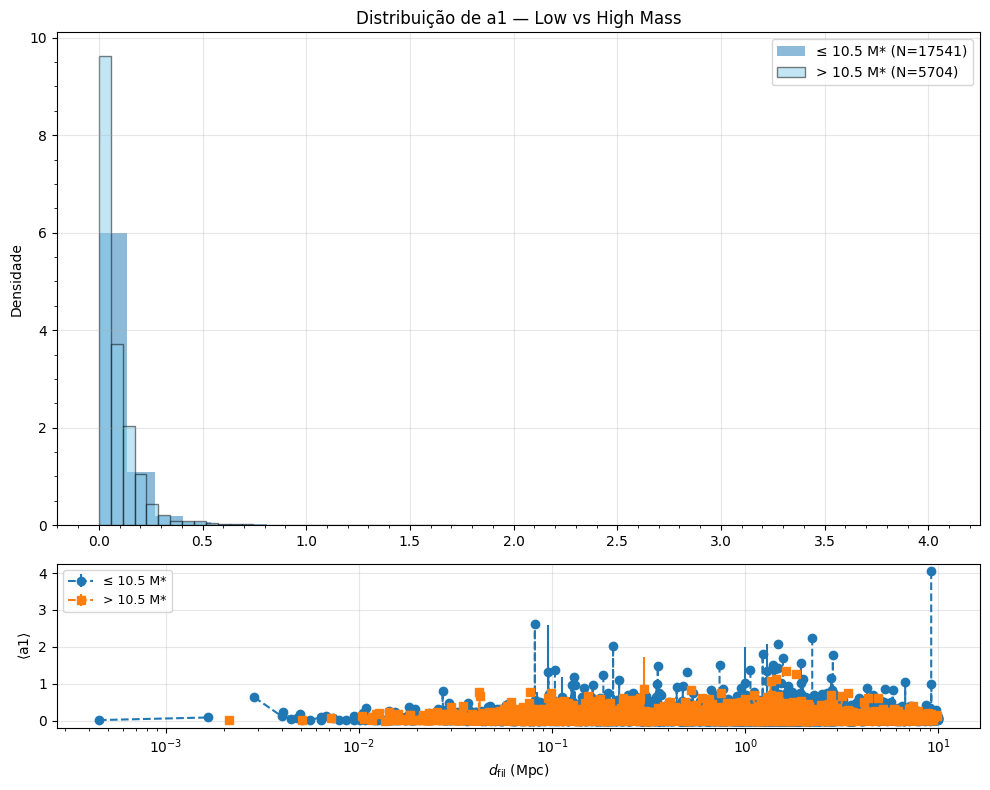

Histograma + média vs distância para a3


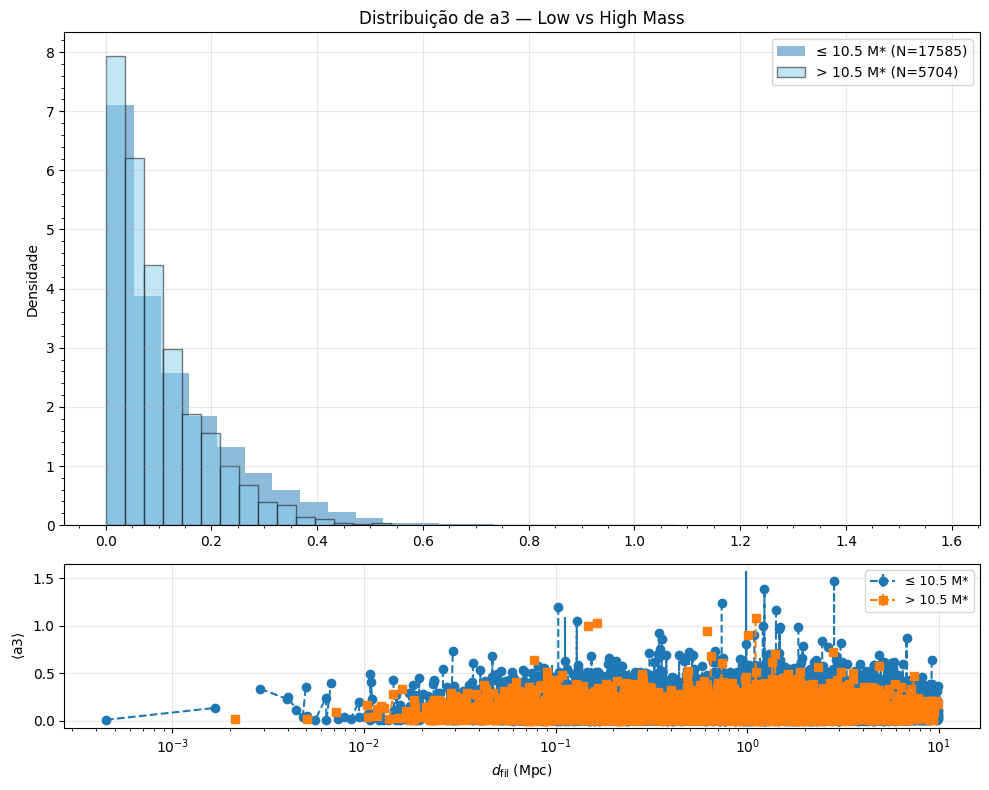

Histograma + média vs distância para c1


/tmp/ipython-input-3197766860.py:122: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(


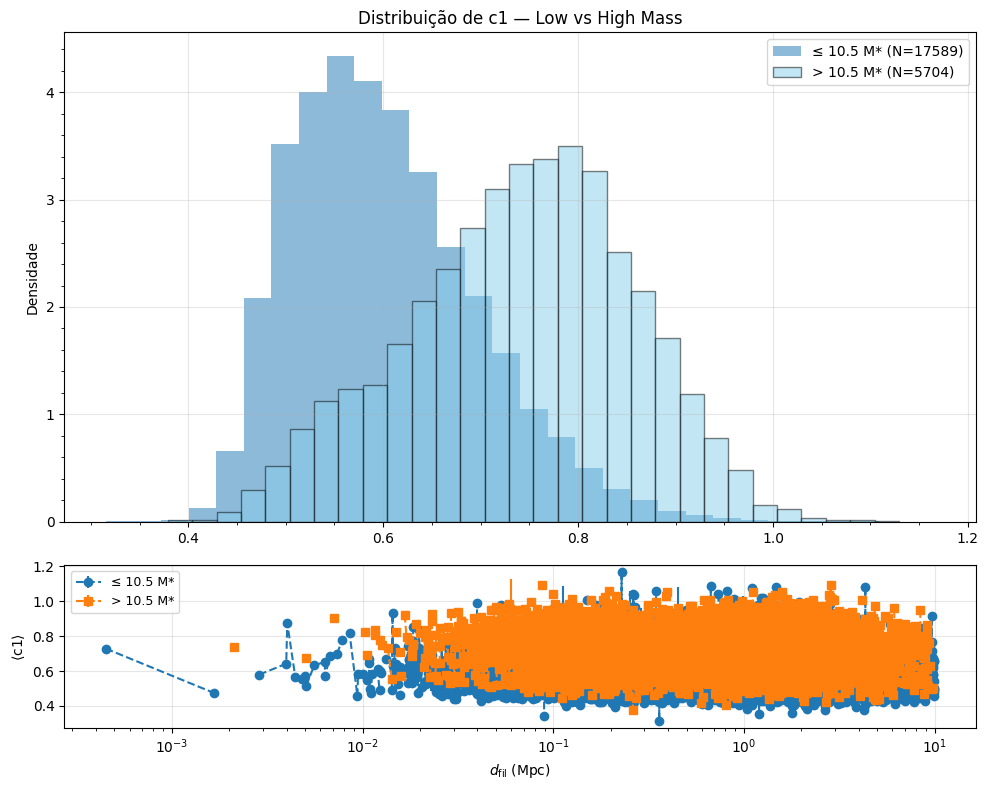

Histograma + média vs distância para c2


In [ ]:
import matplotlib.pyplot as plt

tabela = Table.read(
    "/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/MFMTK_SDSS_clusters_z_logmstars.fits",
    format="fits"
)
df = tabela.to_pandas()
df.columns = [c.lower() for c in df.columns]

col_logMstars = 'logmstars'
col_fildist = 'fil_dist'

# bins reais de fil_dist (já discretizado no seu dataset)
bins_fil = np.sort(df[col_fildist].unique())
bin_centers = bins_fil

parametros_restantes = ["a1", "a3", "c1", "c2", "s1", "s3", "h",
                         "nfit2d", "g", "m20", "sigma_psi"]

morf_plots_dir = "/content/drive/MyDrive/analises_galaxias_setore_novo/mstars_histograms_1"
os.makedirs(morf_plots_dir, exist_ok=True)

for param in parametros_restantes:
    print(f"Histograma + média vs distância para {param}")

    fig, (ax_hist, ax_mean) = plt.subplots(
        2, 1,
        figsize=(10, 8),
        gridspec_kw={'height_ratios': [3, 1]}
    )

    # =========================
    # PAINEL SUPERIOR: HIST
    # =========================
    ax_hist.set_title(f"Distribuição de {param} — Low vs High Mass")
    ax_hist.set_ylabel("Densidade")
    ax_hist.grid(alpha=0.3)
    ax_hist.minorticks_on()

    data_low = df.loc[
        (df[col_logMstars] < 10.5) & (df[param] > 0),
        param
    ].dropna()

    data_high = df.loc[
        (df[col_logMstars] >= 10.5) & (df[param] > 0),
        param
    ].dropna()

    if not data_low.empty:
        ax_hist.hist(
            data_low, bins=30, density=True,
            alpha=0.5, label=f"≤ 10.5 M* (N={len(data_low)})"
        )

    if not data_high.empty:
        ax_hist.hist(
            data_high, bins=30, density=True,
            alpha=0.5, color='skyblue', edgecolor='black',
            label=f"> 10.5 M* (N={len(data_high)})"
        )

    ax_hist.legend()

    # =========================================
    # PAINEL INFERIOR: <param> vs fil_dist
    # =========================================
    mean_low, err_low = [], []
    mean_high, err_high = [], []

    for d in bins_fil:
        # LOW MASS
        vals_low = df.loc[
            (df[col_logMstars] < 10.5) &
            (df[col_fildist] == d) &
            (df[param] > 0),
            param
        ]

        if len(vals_low) > 0:
            mean_low.append(vals_low.mean())
            err_low.append(vals_low.std() / np.sqrt(len(vals_low)))
        else:
            mean_low.append(np.nan)
            err_low.append(np.nan)

        # HIGH MASS
        vals_high = df.loc[
            (df[col_logMstars] >= 10.5) &
            (df[col_fildist] == d) &
            (df[param] > 0),
            param
        ]

        if len(vals_high) > 0:
            mean_high.append(vals_high.mean())
            err_high.append(vals_high.std() / np.sqrt(len(vals_high)))
        else:
            mean_high.append(np.nan)
            err_high.append(np.nan)

    ax_mean.errorbar(
        bin_centers, mean_low, yerr=err_low,
        fmt='o--', label='≤ 10.5 M*'
    )

    ax_mean.errorbar(
        bin_centers, mean_high, yerr=err_high,
        fmt='s--', label='> 10.5 M*'
    )

    ax_mean.set_xscale('log')
    ax_mean.set_xlabel(r'$d_{\mathrm{fil}}\;(\mathrm{Mpc})$')
    ax_mean.set_ylabel(r'$\langle$' + param + r'$\rangle$')
    ax_mean.grid(alpha=0.3)
    ax_mean.legend(fontsize=9)

    plt.tight_layout()
    plt.savefig(
        os.path.join(morf_plots_dir, f"{param}_hist_plus_mean_fil_dist.png"),
        dpi=200
    )
    plt.show()
    plt.close()


##Massa estelar vs redshift


In [ ]:
# @title
#Tabela
df = pd.read_csv("/mfmkt_sdssq0.7.csv")
df.columns = [c.lower() for c in df.columns]

lowmassmask = df['logmstars']<10.5
highmassmask = df['logmstars']>=10.5

parametros_restantes = ["a1", "a3", "c1", "c2", "s1", "s3", "h", "nfit2d", "fil_dist", "l1.0", "l0.5", "ng.5", "ng1", "len", "g", "m20", "sigma_psi", "logsfr"]
#parametros_restantes = ["a1","c1", "h", "nfit2d", "sigma_psi", "logsfr"]


#Pastas de saída
base_dir = "/content/drive/MyDrive/analises_galaxias_setore_modoficado"
os.makedirs(base_dir, exist_ok=True)

y_min_global = np.inf
y_max_global = -np.inf

# Calculate global min/max for y-axis across all parameters to be plotted (if positive values are relevant for log scale)
for param in parametros_restantes:
    # Filter only positive values for calculation, as we will use a log scale
    valores_positivos = df[param][df[param] > 0]

    if not valores_positivos.empty:
        # Update global minimum if a smaller value is found
        y_min_global = min(y_min_global, valores_positivos.min())
        # Update global maximum if a larger value is found
        y_max_global = max(y_max_global, valores_positivos.max())


#Análise e plotagem
for param in parametros_restantes:
    fig, ax = plt.subplots(figsize=(20, 10))
    print(f"Geração de: {param}");

    sns.kdeplot(x=df[lowmassmask]["redshift_1"], y=df[lowmassmask][param], ax=ax, label='Low Mass KDE', fill=False, linestyles='--', levels=5)
    sns.kdeplot(x=df[highmassmask]["redshift_1"], y=df[highmassmask][param], ax=ax, label='High Mass KDE', fill=False, levels=5)

    # Scatter plot for all data points
    ax.scatter(x=df["redshift_1"], y=df[param], s=3, alpha=0.2, color="black", edgecolors="none", zorder=2)

    # Apply log scale if values are all positive in the relevant columns
    if (df[param][lowmassmask].gt(0).all() and df[param][highmassmask].gt(0).all()):
        ax.set_yscale('log')

    if (df["redshift_1"][lowmassmask].gt(0).all() and df["redshift_1"][highmassmask].gt(0).all()):
        ax.set_xscale('log')

    ax.set_xlabel("redshift")
    ax.set_ylabel(param)

    ax.set_ylim(y_min_global, y_max_global)

    ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.grid(alpha=0.3)
    plt.minorticks_on()
    plt.title(f"{param}")

    # Gerar diretório para os plots combinados
    combined_plots_dir = os.path.join(base_dir, "combined_plots_subplots_redshift")
    os.makedirs(combined_plots_dir, exist_ok=True)
    # Salvar
    #plot_filename = os.path.join(combined_plots_dir, f"{param}_combinado.png")
    #plt.savefig(plot_filename)
    plt.show()
    plt.close()

# Comparação cor-fil_dist

In [ ]:
# @title
#Tabela
tabela = Table.read("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/MFMTK_SDSS_clusters_z_logmstars.fits", format="fits")
df = tabela.to_pandas()
df.columns = [c.lower() for c in df.columns]

df.dropna(subset=['mag_u_1', 'mag_g_1', 'mag_r_1'], inplace=True)

# Diretório
base_dir = "/content/drive/MyDrive/analises_galaxias_setore_novo"
cor_fildist_dir = os.path.join(base_dir, "cor-cor-fildist")
os.makedirs(cor_fildist_dir, exist_ok=True)

# Acesso aos dados
if 'mag_u_1' in df.columns and 'mag_g_1' in df.columns and 'mag_r_1' in df.columns:
    df['u_g'] = df.loc[:, 'mag_u_1'] - df.loc[:, 'mag_g_1']
    df['g_r'] = df.loc[:, 'mag_g_1'] - df.loc[:, 'mag_r_1']

    M_sun = 4.64
    #Magnitude absoluta via lumr
    if 'lumr' in df.columns:
        df['M_r'] = -2.5 * np.log10(df['lumr']) + M_sun
        color_data = df['M_r']
        c_label = 'M_r (from lumr)'
    elif 'm-r' in df.columns:
      color_data = df['m-r']
      c_label = 'M_r (from m-r)'
    elif 'mag_r_1' in df.columns:
      color_data = df['mag_r_1']
      c_label = 'r-band magnitude'
    else:
      print("Neither 'lumr', 'm-r', nor 'mag_r_1' columns found to determine color data.");
      color_data = None

    #Filtro
    if color_data is not None:
      dfp = df[
          (df['u_g'] > -0.5) & (df['u_g'] < 3.0) &
          (df['g_r'] > -0.2) & (df['g_r'] < 2.0)
      ].copy()

      #Classificar azul/vermelha (ajuste o limite se quiser)
      limite = 0.6
      df['tipo'] = ['Azul' if gr < limite else 'Vermelha' for gr in df['g_r']]

      #Define azul and vermelha DataFrames here so they are available for both plots
      azul = df[df['tipo'] == 'Azul']
      vermelha = df[df['tipo'] == 'Vermelha']

      #Histograma da distribuição de fildist por tipo de galáxia em um único plot
      plt.figure(figsize=(12, 6))

      plt.hist(azul['fil_dist'], bins=30, alpha=0.6, density=True, label=f'Galáxias Azuis (N={len(azul)})', color='blue')
      plt.hist(vermelha['fil_dist'], bins=30, alpha=0.6, density=True, label=f'Galáxias Vermelhas (N={len(vermelha)})', color='red')

      plt.xlabel('fil_dist')
      plt.ylabel('Densidade')
      plt.title('Densidade de distribuição de fildist — Galáxias Azuis e Vermelhas')
      plt.legend()
      plt.grid(alpha=0.3)
      plt.minorticks_on()


      plt.tight_layout()
      plot_filename = os.path.join(cor_fildist_dir, f"cor-cor-fildist_combined_histogram.png")
      plt.savefig(plot_filename, dpi=300)
      plt.show()
    else:
      print("Could not generate plot due to missing color data.");

else:
    print("Magnitude columns (mag_u_1, mag_g_1, mag_r_1) not found in the DataFrame after dropping NaNs. Cannot create color or tipo columns.");

# Comparando a classificação por setores com a cor

In [ ]:
# @title
#Tabela
tabela = Table.read("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/MFMTK_SDSS_clusters_z_logmstars.fits", format="fits")
df = tabela.to_pandas()
df.columns = [c.lower() for c in df.columns]

df.dropna(subset=['mag_u_1', 'mag_g_1', 'mag_r_1'], inplace=True)
if 'mag_u_1' in df.columns and 'mag_g_1' in df.columns and 'mag_r_1' in df.columns:
    df['u_g'] = df['mag_u_1'] - df['mag_g_1']
    df['g_r'] = df['mag_g_1'] - df['mag_r_1']
    limite = 0.6
    df['tipo'] = ['Azul' if gr < limite else 'Vermelha' for gr in df['g_r']]
else:
    print("Magnitude columns (mag_u_1, mag_g_1, mag_r_1) not found in the DataFrame after dropping NaNs. Cannot create color or tipo columns.")

#Mascaras
lowmassmask = df['logmstars'] < 10.5
highmassmask = df['logmstars'] >= 10.5

for param in parametros_restantes:
    # Filtra apenas valores positivos para cálculo, pois usaremos escala log
    valores_positivos = df[param][df[param] > 0]

    if not valores_positivos.empty:
        # Atualiza o mínimo global se encontrar um valor menor
        y_min_global = min(y_min_global, valores_positivos.min())
        # Atualiza o máximo global se encontrar um valor maior
        y_max_global = max(y_max_global, valores_positivos.max())

#Criar massa-cor
if 'tipo' in df.columns:
    conditions = [
        (lowmassmask & (df['tipo'] == 'Azul')),
        (lowmassmask & (df['tipo'] == 'Vermelha')),
        (highmassmask & (df['tipo'] == 'Azul')),
        (highmassmask & (df['tipo'] == 'Vermelha'))
    ]
    choices = [
        'Low Mass - Blue',
        'Low Mass - Red',
        'High Mass - Blue',
        'High Mass - Red'
    ]
    df['mass_color_category'] = np.select(conditions, choices, default='Unknown')

    #Diretório
    base_dir = "/content/drive/MyDrive/analises_galaxias_setore_novo"
    cor_fildist_dir = os.path.join(base_dir, "cor-cor-fildist")
    os.makedirs(cor_fildist_dir, exist_ok=True)

    #Calculo
    mass_color_counts = df.groupby(['mass_color_category'], observed=False).size().reset_index(name='count')

    #Salvar
    df.to_csv(os.path.join(cor_fildist_dir, 'RGB-galaxias-mass_color_category.csv'), index=False)
    mass_color_counts.to_csv(os.path.join(cor_fildist_dir, 'galaxy_mass_color_counts.csv'), index=False)
    print("Combined mass and color categories created and counts saved.")
else:
    print("Color classification ('tipo' column) not available. Skipping combined classification.")

# Galáxia por cor - parâmetros - M* - fildist

In [ ]:
# @title
#Tabela
tabela = Table.read("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/MFMTK_SDSS_redshift_logMstars.fits", format="fits")
df = tabela.to_pandas()
df.columns = [c.lower() for c in df.columns]

#Magnitudes e bandas
df.dropna(subset=['mag_u', 'mag_g', 'mag_r'], inplace=True)
if 'mag_u' in df.columns and 'mag_g' in df.columns and 'mag_r' in df.columns:
    df['u_g'] = df['mag_u'] - df['mag_g']
    df['g_r'] = df['mag_g'] - df['mag_r']
    limite = 0.6
    df['tipo'] = ['Azul' if gr < limite else 'Vermelha' for gr in df['g_r']]
else:
    print("Magnitude columns (mag_u, mag_g, mag_r) not found in the DataFrame after dropping NaNs. Cannot create color or tipo columns.")


base_dir = '/content/drive/MyDrive/analises_galaxias_setore_novo'
cor_fildist_dir = os.path.join(base_dir, "RGB-fildist-M*")
lowmassmask = df['logmstars'] < 10.5
highmassmask = df['logmstars'] >= 10.5

y_min_global = np.inf
y_max_global = -np.inf

mascara_positiva = df[param] > 0
df_temp_plot = df[mascara_positiva]

#Erro fixo
erro_constante = 0.001

if 'tipo' in df.columns:
    df["setor_cor"] = df.apply(
        lambda row: f"logMstars: {row['setor_logMstars']}, fildist: {row['setor_fildist']}, tipo: {row['tipo']}",
        axis=1
    )


#Combinando Setores
sectors = df.groupby(["setor_logMstars", "setor_fildist"], observed=False).groups.keys()

#Setores
logmstars_sectors = df["setor_logMstars"].unique()

#Cores dos setores
color_map = {}

default_cmap = plt.colormaps.get_cmap('tab10')
num_logmstars_sectors = len(logmstars_sectors)

for i, sector in enumerate(logmstars_sectors):
    sector_str = str(sector)
    if "(lowmassmask]" in sector_str:
        color_map[sector_str] = 'red'
    elif "(highmassmask]" in sector_str:
        color_map[sector_str] = 'yellow'
    else:

        color_map[sector_str] = default_cmap(i / (num_logmstars_sectors - 1) if num_logmstars_sectors > 1 else 0)

#Parâmetros
parametros_restantes = ["a1", "a3", "c1", "c2", "s1", "s3", "h", "nfit2d", "redshift", "l1.0", "l0.5", "ng.5", "ng1", "g", "m20", "sigma_psi", "logsfr"]

#Diretório
combined_plots_dir = os.path.join(base_dir, "RGB-fildist-M*_combined")
os.makedirs(combined_plots_dir, exist_ok=True)

#Plots
for param in parametros_restantes:
    print(f"Generating combined plot for parameter: {param}")
    plt.figure(figsize=(12, 8))
    plt.title(f"{param} vs fil_dist por setor de logMstars e tipo de galáxia")
    plt.xlabel("fil_dist")
    plt.ylabel(param)
    plt.grid(alpha=0.3)
    plt.minorticks_on()

    ax.set_ylim(y_min_global, y_max_global)

    #logMstars e cor
    sorted_logmstars_sectors = sorted(logmstars_sectors, key=lambda x: x.left if pd.notna(x) else float('inf'))
    for logmstars_sector in sorted_logmstars_sectors:
        df_logmstars_sector = df[df["setor_logMstars"] == logmstars_sector].dropna(subset=[param])
        if df_logmstars_sector.empty:
            continue

        color = color_map.get(str(logmstars_sector), 'gray')

        #Azuis
        df_blue = df_logmstars_sector[df_logmstars_sector['tipo'] == 'Azul']
        plt.scatter(df_blue["fil_dist"], df_blue[param], color='blue', marker='o', s=10, label=f"logMstars: {logmstars_sector}, Azul (N={len(df_blue)})")

        #Vermelhas
        df_red = df_logmstars_sector[df_logmstars_sector['tipo'] == 'Vermelha']
        plt.scatter(df_red["fil_dist"], df_red[param], color='red', marker='x', s=10, label=f"logMstars: {logmstars_sector}, Vermelha (N={len(df_red)})")


    #Legenda
    plt.legend(title="Setores e Tipo", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    #Salvar
    plot_filename = os.path.join(combined_plots_dir, f"{param}_fildist_logMstars.png")
    plt.savefig(plot_filename, dpi=300)
    plt.close()

##Massa-metalicidade-**SFR**

#Comparando dados morfológicos com Morfométircos

In [ ]:
# @title
#Tabela
tabela = Table.read("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/MFMTK_SDSS_clusters_z_logmstars.fits", format="fits")
df = tabela.to_pandas()
df.columns = [c.lower() for c in df.columns]

#Colunas
col_morf = 'morf'
col_fildist = 'fil_dist'
col_len = 'len'
col_logMstars = 'logmstars'
col_cor = 'tipo'

#Limites
lowmassmask = df['logmstars'] < 10.5
highmassmask = df['logmstars'] >= 10.5

y_min_global = np.inf
y_max_global = -np.inf

mascara_positiva = df[param] > 0
df_temp_plot = df[mascara_positiva]

for param in parametros_restantes:
    # Filtra apenas valores positivos para cálculo, pois usaremos escala log
    valores_positivos = df[param][df[param] > 0]

    if not valores_positivos.empty:
        # Atualiza o mínimo global se encontrar um valor menor
        y_min_global = min(y_min_global, valores_positivos.min())
        # Atualiza o máximo global se encontrar um valor maior
        y_max_global = max(y_max_global, valores_positivos.max())

#lim_fildist = (0.0, 10.0, 0.5)
#lim_logMstars = (9.5, 11.5, 0.5)

if col_morf in df.columns:
    #Bins setores morfológicos (0, 1, 2)
    bins_morf = np.array([-0.5, 0.5, 1.7, 2.5])
    df["setor_morf"] = pd.cut(df[col_morf], bins=bins_morf, include_lowest=True, right=True, labels=[0, 1, 2])

else:
    print(f"Sem valores")
    bins_morf = None



#bins_logMstars = np.arange(lim_logMstars[0], lim_logMstars[1] + lim_logMstars[2], lim_logMstars[2])
#bins_fildist = np.arange(lim_fildist[0], lim_fildist[1] + lim_fildist[2], lim_fildist[2])

#Setores
#df["setor_logMstars"] = pd.cut(df[col_logMstars], bins=bins_logMstars, include_lowest=True)
#df["setor_fildist"] = pd.cut(df[col_fildist], bins=bins_fildist, include_lowest=True)
#if bins_morf is not None:
 #   df["setor_morf"] = pd.cut(df[col_morf], bins=bins_morf, include_lowest=True, right=True, labels=[0, 1, 2])


#Parâmetros MFMTK's
parametros_to_plot = ["fil_dist", "logmstars", "s1", "s3", "h", "nfit2d", "redshift_1", "l1.0", "l0.5", "ng.5", "ng1", "len", "g", "m20", "sigma_psi", "logsfr"]

#Saída
base_dir = "/content/drive/MyDrive/analises_galaxias_setore_novo"
morf_plots_dir = os.path.join(base_dir, "morfologia_comparacao_histograms")
os.makedirs(morf_plots_dir, exist_ok=True)

if "setor_morf" in df.columns:
    morf_sectors = sorted(df["setor_morf"].dropna().unique())

    for param in parametros_to_plot:
        print(f"Historograma morfologia vs {param}")
        plt.figure(figsize=(10, 6))
        plt.title(f"Distribuição de {param} por setor morfológico")
        plt.xlabel(param)
        plt.ylabel("Densidade")
        plt.grid(alpha=0.3)
        plt.minorticks_on()

        #Histogramas
        for sector in morf_sectors:
            data_to_plot = df[df["setor_morf"] == sector].dropna(subset=[param])[param]
            if not data_to_plot.empty:
                plt.hist(
                   data_to_plot,
                   bins=30,
                   alpha=0.5,
                   density=True,  # NORMALIZA O HISTOGRAMA
                   label=f"Morfologia: {sector} (N={len(data_to_plot)})"
                )
        plt.legend(title="Setores Morfológicos")
        plt.tight_layout()

        ax.set_ylim(y_min_global, y_max_global)

        #Salvar
        plot_filename = os.path.join(morf_plots_dir, f"morfologia_vs_{param}_histogram.png")
        plt.savefig(plot_filename, dpi=300)
        plt.close()

#Cálculo de densidade ρ(r) dos filamentos

raio do filamento (Bisous) $r = 0.5 h^{-1} Mpc$, logo essa é a região interna do filamento modelado, para $d = 1.0 h^{-1} Mpc$ estamos na parede ou campo, assim, a densidade do filamento deve ser calculada para sua região interna, desta forma relacionarei o número de galáxias com o Len e $π r^{2}$, por ser um modelo cilindrico.

In [ ]:
# @title
tabela = Table.read("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/MFMTK_SDSS_clusters_z_logmstars.fits", format="fits")
df = tabela.to_pandas()
df.columns = [c.lower() for c in df.columns]

#raio de bisous
r_fil = 0.5  # h^-1 Mpc
r_parede = 1.0

#Parâmetros
parametros_restantes = ["a1", "a3", "c1", "c2", "s1", "s3", "h", "nfit2d", "redshift"]
parametros_filamento = ["len", "redshift_1","l1.0", "l0.5", "n1.0", "n0.5", "nrich", "w"]

#Colunas para densidade de filamento, parede
col_ng_5 = "ng.5"
col_ng1 = "ng1"
col_len = "len"

# Limites
limit_filamento = (0.0, 0.5)
limit_parede = (0.5, 1.0)
limit_campo = (1.0, 10)

#Cálculo de densidade para filamento, parede e campo
df["rho_fil"] = df[col_ng_5] / (np.pi * (r_fil**2) * df[col_len]) #função para calcular a densidade de filamento
df["rho_wall"] = (df[col_ng1] - df[col_ng_5]) / (np.pi * ((r_parede**2 - r_fil**2)) * df[col_len]) #função para calcular a densidade de parede
rho_med = df['ng1'].sum() / (np.pi * (r_parede**2) * df['len'].sum()) #Média de densidade
df['rho_field'] = rho_med - (df['rho_fil'] + df['rho_wall']) #função para calcular a densidade do campo


#Médias
mean_rho_fil = df["rho_fil"].mean()
mean_rho_wall = df["rho_wall"].mean()
mean_rho_field = df["rho_field"].mean()


#Número de galáxias por setor
galaxias_na_filamento = df[(df['fil_dist'] > limit_filamento[0]) & (df['fil_dist'] <= limit_filamento[1])].shape[0]
galaxias_na_parede = df[(df['fil_dist'] > limit_parede[0]) & (df['fil_dist'] <= limit_parede[1])].shape[0]
galaxias_no_campo = df[(df['fil_dist'] > limit_campo[0]) & (df['fil_dist'] <= limit_campo[1])].shape[0]

#Número de galáxias total
total_galaxias = len(df)

print(f"Média rho_fil: {mean_rho_fil}")
print(f"Média rho_wall: {mean_rho_wall}")
print(f"Média rho_field: {mean_rho_field}")
print(f"Número de galáxias no {limit_filamento} h^-1 Mpc (filamento): {galaxias_na_filamento}")
print(f"Número de galáxias na {limit_parede} h^-1 Mpc (parede): {galaxias_na_parede}")
print(f"Número de galáxias no {limit_campo} h^-1 Mpc (campo): {galaxias_no_campo}")
print(f"Total de galáxias (amostra): {total_galaxias}")

In [ ]:
# @title
plt.figure(figsize=(10, 6))
plt.scatter(df['fil_dist'], df['rho_fil'], label='rho_fil', s=10)
plt.scatter(df['fil_dist'], df['rho_wall'], label='rho_wall', s=10)
plt.scatter(df['fil_dist'], df['rho_field'], label='rho_field', s=10)

plt.xlabel('fil_dist')
plt.ylabel('Densidade')
plt.title('Densidade vs fil_dist')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid(alpha=0.3)
plt.minorticks_on()
plt.show()

##Morfometria-densidade

In [ ]:
# @title
#Diretório
base_dir = "/content/drive/MyDrive/analises_galaxias_setore_novo"

density_plots_dir = os.path.join(base_dir, "morfometria_densidade")
os.makedirs(density_plots_dir, exist_ok=True)

for param in parametros_restantes:
    print(f"Geração de gráfico de densidade: {param}")
    for density_col in density_columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(df[density_col], df[param], s=5, alpha=0.5)

        plt.xlabel(density_col)
        plt.ylabel(param)
        plt.title(f"{param} vs {density_col}")
        #Log
        if (df[density_col] > 0).any():
            plt.xscale('log')
        if (df[param] > 0).any():
            plt.yscale('log')

        plt.grid(alpha=0.3)
        plt.minorticks_on()
        plt.tight_layout()

        #Salvar
        plot_filename = os.path.join(density_plots_dir, f"{param}_vs_{density_col}.png")
        plt.savefig(plot_filename, dpi=300)
        plt.close()

Galáxias azuius compõem 9225 do total da população, já as vermelhas são no total de 14068 galáxias, enquanto isso, para as morf. temos: 12192 - espirais, 3720 - elipticas e 7381 - indefinidas. Fazendo uma simples comparação, chegamos a estimativa de que 5505 serão azuis e 1876 vermelhas. %A confirmar.



##Densidade-largura do filamento

Aqui só considerar o diâmetro da região cilindrica dos filamnentos de bisous e a densidade média, fazendo assim a relação, logo o número de galáxias para 1.0 e a luminosidade 1.0.

Análise estatística da variação dos parâmetros em diferentes regiões do

---

filamento, assim como a relação entre si e entre as componentes do filamento e de grupos $Len$, $N_{gal}$, $fildist$, $N_{rich}$, $L_{ij}$, $N_{ij}$, $ρ_{setor}$. Na cosmologia seria uma análise por GRF, do filamento em si, mas como estamos tratando com galáxias, o uso de multivariáveis pode ser útil.

##Densidade (teste) logM*

##Densidade subjacente dos filamentos

Estudar as interações gravitacionais pela distribuição das galáxias, evolução do potêncial, aplicar Press-schechter estendido, campo de densidade subjacente das galáxias.

#Relação de parâmetros - anexo

**OBSERVAÇÃO**: relação entre parâmetros MFMTK's e propriedades de filamento não é intrinsecamente fácil de detectar, visto que o modelamento dos filamentos visa a descrição em larga escala destes e não a propriedade de galáxias (e seu processo evolucionário particular), para entender melhor isto, aparentemente devo focar na natureza dos grupos, tentando visualizar a correlação de caracteristicas de galáxias que interagem, sua posição e asism enteder o meio.

In [ ]:
#Correlação Pearson
# Matriz de correlação fil ==> MFMTK
table = Table.read("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/MFMTK_SDSS_clusters_z_logmstars.fits", format="fits")
df = pd.DataFrame(table.to_pandas())
df.columns = [c.lower() for c in df.columns]

base_dir = '/content/drive/MyDrive/analises_galaxias_setore_novo'
os.makedirs(base_dir, exist_ok=True)

# parâmetros
parametros_desejados = ["a1", "a3", "s1", "s3", "c1", "c2", "h", "g", "nfit2d", "sigma_psi", "morf", "fil_dist", "logmstars", "len", "l1.0", "l0.5", "n1.0", "n0.5"]

# Filter to include only existing columns
parametros_existentes = [param for param in parametros_desejados if param in df.columns]

# Convert relevant existing columns to numeric, coercing errors to NaN
for param in parametros_existentes:
    df[param] = pd.to_numeric(df[param], errors='coerce')

# Matriz de correlação (parâmetros)
correlation_matrix = df[parametros_existentes].corr()

# Mostrar
if correlation_matrix is not None:
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Matriz de correlação')
    plt.show()

    # Gerar diretório para os plots
    correlation_plots_dir = os.path.join(base_dir, "correlation_plots")
    os.makedirs(correlation_plots_dir, exist_ok=True)

    # Salvar
    plot_filename = os.path.join(correlation_plots_dir, "correlation_matrix.png")
    plt.savefig(plot_filename)
    plt.close() # Close the plot to free up memory


In [ ]:
#Spearman (relações não-lineares)
table = Table.read("/content/drive/MyDrive/FURG/Mestrado - Física/Pré-projeto - FURG/Amostragem e datasets/Database/MFMTK_SDSS_clusters_z_logmstars.fits", format="fits")
df = pd.DataFrame(table.to_pandas())
df.columns = [c.lower() for c in df.columns]

base_dir = '/content/drive/MyDrive/analises_galaxias_setore_novo'
os.makedirs(base_dir, exist_ok=True)


parametros = ["a1", "a3", "s1", "s3", "c1", "c2", "h", "g", "nfit2d", "sigma_psi", "n1.0", "n0.5", "l1.0", "l0.5", "fil_dist", "logmstars"]

# Filter to include only existing columns from the 'parametros' list
for param in parametros_existentes:
    df[param] = pd.to_numeric(df[param], errors='coerce')
    print(param, df[param].isna().sum(), "NaNs")

# Convert relevant existing columns to numeric, coercing errors to NaN
for param in parametros_existentes:
    df[param] = pd.to_numeric(df[param], errors='coerce')

# Calculate correlation only for the existing and numeric columns
corr = df[parametros_existentes].corr(method="spearman")
print(corr)
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')

# Criar tabela na figura
tbl = ax.table(
    cellText=corr.round(3).values,
    colLabels=corr.columns,
    rowLabels=corr.index,
    loc='center'
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

# Salvar como imagem
plt.show()
plt.close()

print("Imagem salva como correlacao_spearman.png")